In [1]:
import pandas as pd  # Library untuk manipulasi data dalam bentuk DataFrame
import numpy as np  # Library untuk komputasi numerik, operasi array, dan matriks
import matplotlib.pyplot as plt  # Library untuk membuat visualisasi grafik
import seaborn as sns  # Library untuk visualisasi data statistik
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV  # Fungsi untuk membagi data dan mencari hyperparameter terbaik
from sklearn.svm import SVC  # Support Vector Classifier, digunakan untuk klasifikasi
from yellowbrick.classifier import ROCAUC  # Visualisasi ROC curve dari library Yellowbrick
from imblearn.over_sampling import SMOTE  # Teknik untuk menangani data yang tidak seimbang dengan oversampling kelas minoritas
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score  # Evaluasi model seperti ROC curve, AUC, precision, recall, dan akurasi
from sklearn.metrics import confusion_matrix
import gdown
from google.colab import drive

In [2]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset Skripsi/data_preprocessed.csv')

Mounted at /content/drive


In [3]:
df.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,moid
0,-1.404852,1.458702,1.572803,0.816947,0.813685,0,0.105261
1,-1.628087,2.083379,2.152058,2.280802,0.701647,1,0.030238
2,-0.599112,0.075635,0.147109,-0.979324,1.247151,0,0.059966
3,-0.885132,0.436994,0.542769,1.090705,-0.513372,0,0.154436
4,-0.163105,-0.288098,-0.272000,0.215038,1.051623,0,0.034305


In [4]:
# Memisahkan kolom fitur dan target
X = df.drop(columns=['is_hazardous']) # Fitur
y = df['is_hazardous'] # Target

In [5]:
# Menangani data yang tidak seimbang pada kolom target (is hazardous)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Original y distribution: {y.value_counts()}')
print(f'Resampled y distribution: {pd.Series(y_resampled).value_counts()}')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original y distribution: is_hazardous
0    267017
1     35632
Name: count, dtype: int64
Resampled y distribution: is_hazardous
0    267017
1    267017
Name: count, dtype: int64


In [6]:
# Membagi data menjadi data training dan data test dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Melihat jumlah data pada training set dan test set
print(f'Jumlah data pada training set (X_train): {len(X_train)}')
print(f'Jumlah data pada test set (X_test): {len(X_test)}')
print(f'Jumlah label pada training set (y_train): {len(y_train)}')
print(f'Jumlah label pada test set (y_test): {len(y_test)}')

Jumlah data pada training set (X_train): 427227
Jumlah data pada test set (X_test): 106807
Jumlah label pada training set (y_train): 427227
Jumlah label pada test set (y_test): 106807


In [7]:
# Membangun model dasar SVC
model_svc_baseline = SVC(probability=True, random_state=42)
model_svc_baseline.fit(X_train, y_train)

# Evaluasi model dasar
y_pred_svc_baseline = model_svc_baseline.predict(X_test)
y_prob_svc_baseline = model_svc_baseline.predict_proba(X_test)[:, 1]  # Probabilitas untuk kelas positif

# Menampilkan hasil evaluasi
print("SVC Baseline Model Performance:")
print(classification_report(y_test, y_pred_svc_baseline))

accuracy_svc_baseline = accuracy_score(y_test, y_pred_svc_baseline)
roc_auc_svc_baseline = roc_auc_score(y_test, y_prob_svc_baseline)

print(f"Accuracy: {accuracy_svc_baseline}")
print(f"ROC AUC: {roc_auc_svc_baseline}")

SVC Baseline Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     53361
           1       0.96      1.00      0.98     53446

    accuracy                           0.98    106807
   macro avg       0.98      0.98      0.98    106807
weighted avg       0.98      0.98      0.98    106807

Accuracy: 0.9770427031936109
ROC AUC: 0.9986347090352056


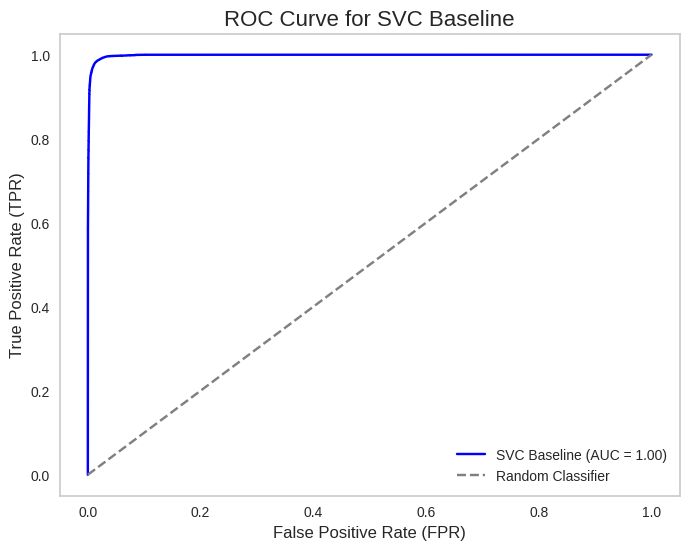

In [8]:
# Menghitung kurva ROC untuk SVC
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_prob_svc_baseline)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Membuat plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='blue', label=f'SVC Baseline (AUC = {roc_auc_svc:.2f})')

# Menambahkan garis diagonal untuk baseline (model random)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Pengaturan plot
plt.title('ROC Curve for SVC Baseline', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show()

Confusion Matrix:
[[51076  2285]
 [  167 53279]]


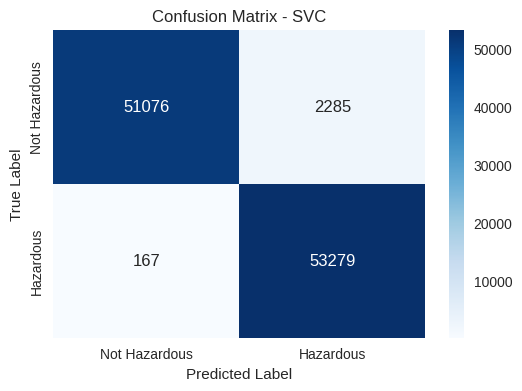

In [9]:
# Confusion Matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc_baseline)
print("Confusion Matrix:")
print(conf_matrix_svc)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hazardous', 'Hazardous'],
            yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVC')
plt.show()

In [11]:
import joblib

# Simpan file ke folder di Google Drive
joblib.dump(model_svc_baseline, '/content/drive/My Drive/model_svc_baseline.pkl')

['/content/drive/My Drive/model_svc_baseline.pkl']